In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Ensure that the CDS and NMME folders and files can be read

In [ ]:
import os

folder_path = '/content/drive/My Drive/capstone_data/NMME'

files = os.listdir(folder_path)

# View all files in NMME
for file in files:
    print("NMME Files:")
    print(file)

NMME Files:
prec.CanESM5.1991.mon_Apr.nc


In [ ]:
# View all files in CDS
folder_path = '/content/drive/My Drive/capstone_data/CDS'

files = os.listdir(folder_path)

for file in files:
    print("CDS Files:")
    print(file)

CDS Files:
prec.ECMWF.2024.mon_Dec.nc


In [ ]:
# xarray to read NETCDF
import xarray as xr

# Load a sample dataset (NMME)
file_path = '/content/drive/My Drive/capstone_data/NMME/prec.CanESM5.1991.mon_Apr.nc'
ds = xr.open_dataset(file_path)

# View dataset info
print(ds)

<xarray.Dataset> Size: 63MB
Dimensions:  (Y: 181, L: 12, X: 360, M: 20, S: 1)
Coordinates:
  * Y        (Y) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * L        (L) float32 48B 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5
  * X        (X) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * M        (M) float32 80B 1.0 2.0 3.0 4.0 5.0 ... 16.0 17.0 18.0 19.0 20.0
  * S        (S) datetime64[ns] 8B 1991-04-01
Data variables:
    prec     (S, L, M, Y, X) float32 63MB ...


In [ ]:
# View NMME data as data frame
# Select a specific slice of data
precip_slice = ds['prec']

# Convert to a pandas DataFrame (flatten the 2D array to 1D)
precip_df = precip_slice.to_dataframe().reset_index()

# View the first few rows of the DataFrame
print(precip_df)
print(precip_df.columns)

                  S     L     M     Y      X      prec
0        1991-04-01   0.5   1.0 -90.0    0.0  0.514423
1        1991-04-01   0.5   1.0 -90.0    1.0  0.514423
2        1991-04-01   0.5   1.0 -90.0    2.0  0.514423
3        1991-04-01   0.5   1.0 -90.0    3.0  0.514423
4        1991-04-01   0.5   1.0 -90.0    4.0  0.514423
...             ...   ...   ...   ...    ...       ...
15638395 1991-04-01  11.5  20.0  90.0  355.0  0.437545
15638396 1991-04-01  11.5  20.0  90.0  356.0  0.437545
15638397 1991-04-01  11.5  20.0  90.0  357.0  0.437545
15638398 1991-04-01  11.5  20.0  90.0  358.0  0.437545
15638399 1991-04-01  11.5  20.0  90.0  359.0  0.437545

[15638400 rows x 6 columns]
Index(['S', 'L', 'M', 'Y', 'X', 'prec'], dtype='object')


In [ ]:
# Open CDS dataset (unmodified)
file_path = '/content/drive/My Drive/capstone_data/CDS/prec.ECMWF.2024.mon_Dec.nc'

ds_cds_og = xr.open_dataset(file_path)

# View dataset info
print(ds_cds_og)

<xarray.Dataset> Size: 79MB
Dimensions:                  (number: 51, forecast_reference_time: 1,
                              forecastMonth: 6, latitude: 180, longitude: 360)
Coordinates:
  * number                   (number) int64 408B 0 1 2 3 4 5 ... 46 47 48 49 50
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 8B 2024...
  * forecastMonth            (forecastMonth) int64 48B 1 2 3 4 5 6
  * latitude                 (latitude) float64 1kB 89.5 88.5 ... -88.5 -89.5
  * longitude                (longitude) float64 3kB 0.5 1.5 2.5 ... 358.5 359.5
Data variables:
    tprate                   (forecastMonth, forecast_reference_time, number, latitude, longitude) float32 79MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weath

In [ ]:
# View original CDS as dataframe
precip_slice = ds_cds_og['tprate']

# Convert to a pandas DataFrame (flatten the 2D array to 1D)
precip_df = precip_slice.to_dataframe().reset_index()

# View the first few rows of the DataFrame
print(precip_df)
print(precip_df.columns)

          forecastMonth forecast_reference_time  number  latitude  longitude  \
0                     1              2024-12-01       0      89.5        0.5   
1                     1              2024-12-01       0      89.5        1.5   
2                     1              2024-12-01       0      89.5        2.5   
3                     1              2024-12-01       0      89.5        3.5   
4                     1              2024-12-01       0      89.5        4.5   
...                 ...                     ...     ...       ...        ...   
19828795              6              2024-12-01      50     -89.5      355.5   
19828796              6              2024-12-01      50     -89.5      356.5   
19828797              6              2024-12-01      50     -89.5      357.5   
19828798              6              2024-12-01      50     -89.5      358.5   
19828799              6              2024-12-01      50     -89.5      359.5   

                tprate  
0         6.65

In [ ]:
# A function that converts CDS data to NMME

# Import necessary libraries
import pandas as pd
import xarray as xr
import os

"""
TODO
Spatial extent problem (interpolation? regridding? nearest neighbor?)

The current method (nearest neighbor) increases datapoints in the CDS dataset by about 11000
for the given example, but the tolerance is adjustable (If the absolute difference between a source coordinate and a
target coordinate is less than or equal to the tolerance value,
they are considered a match). Since we know that each coordinate is off by 0.5, what can we do with this info?

Half-month increments:
The NMME data use Month increments of 0.5, while the CDS data use 1 through 6.
Is this a problem? how can it be solved?
"""

# CDS folder path to modify
CDS_folder_path = '/content/drive/My Drive/capstone_data/CDS'

# NMME file as a spatial reference
NMME_file_path = '/content/drive/My Drive/capstone_data/NMME/prec.CanESM5.1991.mon_Apr.nc'

# Path to save modifed CDS files
save_path = '/content/drive/My Drive/capstone_data/CDS_converted'

# define conversion function
def convert_CDS_to_NMME(CDS_folder_path, NMME_file_path, save_path):
  """ This function takes a folder path containing CDS NETCDF files, and
      converts them so that it follows a similar variable naming convention
      and spatial extent as a reference NMME dataset. Each modified file is
      stored to a defined save path with an extension of "_modified.nc"

      Arguments: CDS_folder_path - a folder path to CDS data to be modified
                 NMME_file_path - a file path to NMME data for spatial reference
                 save_path - a folder path to save the modified CDS files

      Function Outline:
      1. Open NMME reference file, store for spatial reference
      2. Loop through all files in CDS folder
          a. Open the current CDS NETCDF file and change all variable names to match
         NMME data (manually named, e.g. "longitude" renamed to "X")
          b. Convert 'tprate' from m/sec to mm/day with rate of 86400000, rename to 'prec'
          c. Use nearest neighbors to estimate and reindex CDS data to NMME grid.
             The tolerance parameter for this method can be experiemnted with.
             (If the absolute difference between a source coordinate and a
             target coordinate is less than or equal to the tolerance value,
             they are considered a match.)
          d. Save file to save_path folder with extension "_modified.nc"

      Assumptions and Usage Guidelines:
      1. Python and Package Versions:
         a. Python - 3.10
         b. pandas - 2.2.3
         c. xarray - 2025.1.1
      2. Ensure that the intended file paths follow this format:
         a. CDS folder path: "C:/Users/name/OneDrive/Documents/CDS_folder"
         b. NMME file path: "C:/Users/name/OneDrive/Documents/NMME_folder/NMME_data1.nc"
         c. Save path: "C:/Users/name/OneDrive/Documents/save_folder"
         d. Do not have any slashes at the end of the paths
         e. You can name the folders anything you desire and at any location.
  """

  # Load a reference NMME file to get spatial extent
  nmme_ds = xr.open_dataset(NMME_file_path)

  # Get CDS file names from CDS folder
  file_names = os.listdir(CDS_folder_path)

  # Loop through all CDS files
  for file in file_names:

    print(f'Currently Modifying: {file}')

    # Load the dataset (CDS)
    current_file = f'{CDS_folder_path}/{file}'

    # Assign current dataset
    current_ds = xr.open_dataset(current_file)

    # rename tprate to prec to match NMME data, and convert m/sec to mm/day.
    current_ds['prec'] = current_ds['tprate'] * 86400000

    # Rename longitude to X
    current_ds = current_ds.rename({'longitude': 'X'})

    # Rename latitude to Y
    current_ds = current_ds.rename({'latitude': 'Y'})

    # Rename forecast_month to L (do we need to subtract by 0.5?)
    current_ds = current_ds.rename({'forecastMonth': 'L'})

    # Rename number to M
    current_ds = current_ds.rename({'number': 'M'})

    # Rename forecast_reference_time to S
    current_ds = current_ds.rename({'forecast_reference_time': 'S'})

    # drops the original tprate variable
    current_ds = current_ds.drop_vars('tprate')

    # Reindex to NMME grid using nearest-neighbor
    # Adjust tolerance if needed
    current_ds = current_ds.reindex(
            Y=nmme_ds['Y'],
            X=nmme_ds['X'],
            method='nearest',
            tolerance=1
        )

    # Save the file to the CDS_converted folder, with the same name + _modified
    current_ds.to_netcdf(f'{save_path}/{file[0:-3]}_modified.nc')

    print(f'Successfully Modified: {file}')
    print(f"Saved in: {save_path}/{file[0:-3]}_modified.nc")


# call the function
convert_CDS_to_NMME(CDS_folder_path, NMME_file_path, save_path)

Currently Modifying: prec.ECMWF.2024.mon_Dec.nc
Successfully Modified: prec.ECMWF.2024.mon_Dec.nc
Saved in: /content/drive/My Drive/capstone_data/CDS_converted/prec.ECMWF.2024.mon_Dec_modified.nc


In [ ]:
# Open modified CDS data sample
file_path = '/content/drive/My Drive/capstone_data/CDS_converted/prec.ECMWF.2024.mon_Dec_modified.nc'

## Load the dataset (CDS)
ds_cds_modified = xr.open_dataset(file_path)

# View dataset info
print(ds_cds_modified)

# we see that the names have been modified accordingly

<xarray.Dataset> Size: 160MB
Dimensions:  (X: 360, Y: 181, M: 51, L: 6, S: 1)
Coordinates:
  * X        (X) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * Y        (Y) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * M        (M) int32 204B 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * L        (L) int32 24B 1 2 3 4 5 6
  * S        (S) datetime64[ns] 8B 2024-12-01
Data variables:
    prec     (L, S, M, Y, X) float64 160MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-10T22:44 GRIB to CDM+CF via cfgrib-0.9.1...


In [ ]:
# View modified CDS as dataframe
precip_slice = ds_cds_modified['prec']

# Convert to a pandas DataFrame (flatten the 2D array to 1D)
precip_df = precip_slice.to_dataframe().reset_index()

# View the first few rows of the DataFrame
print(precip_df)
print(precip_df.columns)

# The prec values have been scaled accordingly, and the X and Y values match NMME coords

          L          S   M     Y      X      prec
0         1 2024-12-01   0 -90.0    0.0  0.039604
1         1 2024-12-01   0 -90.0    1.0  0.039604
2         1 2024-12-01   0 -90.0    2.0  0.039604
3         1 2024-12-01   0 -90.0    3.0  0.038976
4         1 2024-12-01   0 -90.0    4.0  0.038976
...      ..        ...  ..   ...    ...       ...
19938955  6 2024-12-01  50  90.0  355.0  0.516116
19938956  6 2024-12-01  50  90.0  356.0  0.518002
19938957  6 2024-12-01  50  90.0  357.0  0.519888
19938958  6 2024-12-01  50  90.0  358.0  0.521773
19938959  6 2024-12-01  50  90.0  359.0  0.523659

[19938960 rows x 6 columns]
Index(['L', 'S', 'M', 'Y', 'X', 'prec'], dtype='object')


In [ ]:
# View a datapoint to see if prec has been estimated well by nearest neighbors

# Convert 'tprate' from m/s to mm/day and extract as a slice
precip_slice_og = ds_cds_og['tprate'] * 86400000

# Convert the xarray DataArray to a pandas DataFrame
precip_df_og = precip_slice_og.to_dataframe().reset_index()

# Select rows where latitude is 89.5 and longitude is 359
selected_data = precip_df_og[(precip_df_og['latitude'] == 89.5) & (precip_df_og['longitude'] == 358.5) & (precip_df_og['forecastMonth'] == 6) & (precip_df_og['number'] == 50)]

# View the selected rows
print("OG Data: tprate Scaled Sample")
print(selected_data)

# Using L(forecastMonth) = 6, X(longitude) = 358.5, Y(latitude) = 89.5, number = 50 as a reference point
# Modified data point: 0.523659
# Original data point: 0.521773

OG Data: tprate Scaled Sample
          forecastMonth forecast_reference_time  number  latitude  longitude  \
19764358              6              2024-12-01      50      89.5      358.5   

            tprate  
19764358  0.521773  


In [ ]:
# Extract OG tprate (prec), scale it, and compute avg difference scores between it and modified (nearest neighbors)

og_tprate_values_scaled = ds_cds_og['tprate'].values * 86400000
modified_tprate_values = ds_cds['prec'].values

# Compute the difference between the average of each arrays

# compute the mean of og tprate values scaled
print(f'Mean of OG tprate (prec) values (Scaled): {og_tprate_values_scaled.mean()}')

# compute the modified tprate values scaled, with nearest neighbors spatial modification
print(f'Mean of modified tprate (prec) values, scaled and spatially extended: {modified_tprate_values.mean()}')

# Compute the difference
average_difference = abs(og_tprate_values_scaled.mean() - modified_tprate_values.mean())

print(f'Difference between the two groups: {average_difference}')

# it seems that the nearest neighbors works pretty well on average, with an
# average difference of 0.01

# is this correct?

Mean of OG tprate (prec) values (Scaled): 2.4208123206161214
Mean of modified tprate (prec) values, scaled and spatially extended: 2.4102437176114413
Difference between the two groups: 0.0105686030046801


# Regional Averaged Monthly Time Series

Using the CHIRPS 2.0 data, perform a time series analysis based on the region.

1. Subset coordinates to get different regions
2. Draw graphs of time series
3. Run arima and prophet etc.
4. Analyze
5. Create a function to do a time series for any data

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Define file path of data
regional_file_path = '/content/drive/My Drive/capstone_data/region_avg_month_ts/chirps-v2.0.monthly.nc'

# Load the dataset (CDS)
regional_data = xr.open_dataset(regional_file_path)

# View the data
print(regional_data)

<xarray.Dataset> Size: 30GB
Dimensions:    (latitude: 2000, longitude: 7200, time: 528)
Coordinates:
  * latitude   (latitude) float32 8kB -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time       (time) datetime64[ns] 4kB 1981-01-01 1981-02-01 ... 2024-12-01
Data variables:
    precip     (time, latitude, longitude) float32 30GB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2025-01-15
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given month.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/ch

In [ ]:
# View regional data as dataframe
time_series_data = regional_data['precip']

# South Sudan Time Series

Experiemental FEWS NET Flood forecasting



In [ ]:
# Subset South Sudan Region
# Lat lower: 3.5
# Lat upper: 12.5
# longitude left: 25
# longitude right: 35

min_lat = 3.5
max_lat = 12.5
min_lon = 25
max_lon = 35

south_sudan_data = time_series_data.sel(latitude=slice(min_lat, max_lat), longitude=slice(min_lon, max_lon))

In [ ]:
south_sudan_time_series = south_sudan_data.mean(dim=['latitude', 'longitude']).to_series()

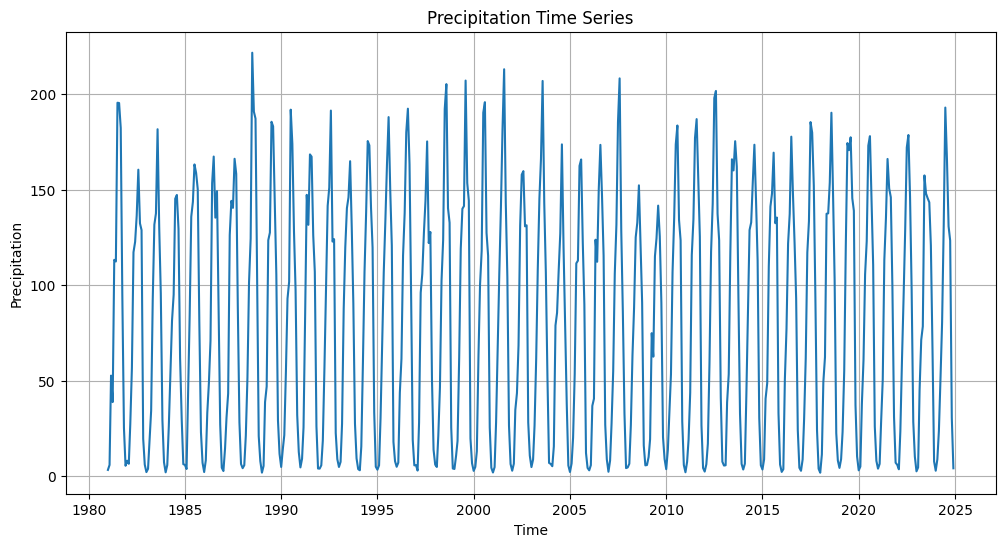

In [ ]:
# Yearly time series plot (Monthly is extremely visually cluttered)
plt.figure(figsize=(12, 6))
plt.plot(south_sudan_time_series.index, south_sudan_time_series.values)
plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.title('Precipitation Time Series')
plt.grid(True)
plt.show()

In [ ]:
south_sudan_time_series.describe()  # Provides summary statistics

,precip
count,528.000000
mean,80.398514
std,63.869160
min,1.822539
25%,14.087020
50%,79.667484
75%,135.450462
max,221.746445


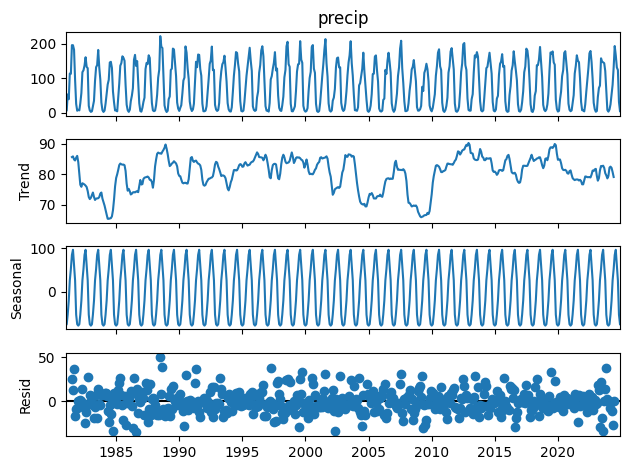

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Explain these plots

result = seasonal_decompose(south_sudan_time_series, model='additive')
result.plot()
plt.show()

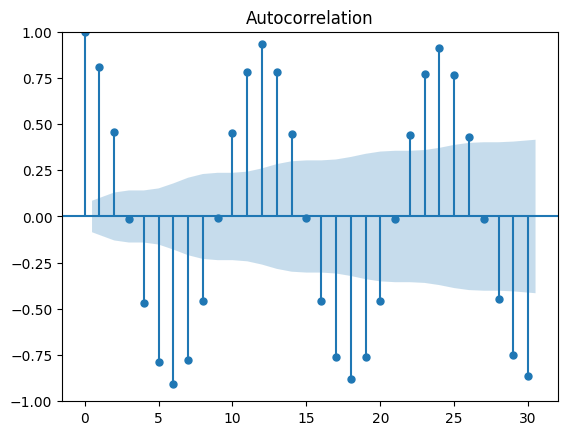

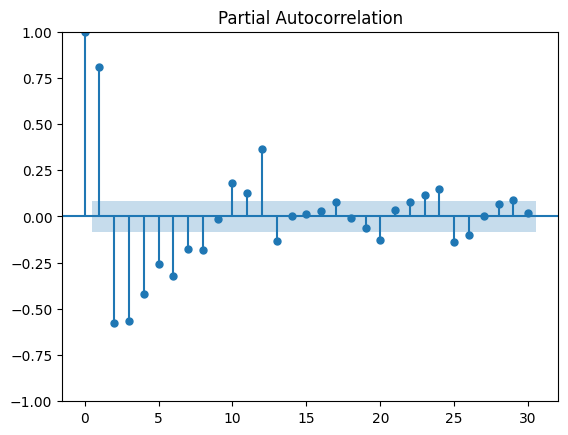

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Explain these plots

plot_acf(south_sudan_time_series, lags=30)
plot_pacf(south_sudan_time_series, lags=30)
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA forecasting using 98 percent of the original data to predict the next 2 percent
forecast_horizon = int(len(south_sudan_time_series) * 0.02)  # 2% of the data for forecasting
train_data_len = len(south_sudan_time_series) - forecast_horizon  # 98% of the data for training

# Create the ARIMA model
model = ARIMA(south_sudan_time_series[:train_data_len], order=(1, 0, 12)) # (p, q, d)

# Fit the model to the training data
model_fit = model.fit()

# Make predictions for the next 30% of the data
predictions = model_fit.predict(start=train_data_len, end=len(south_sudan_time_series) -1)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


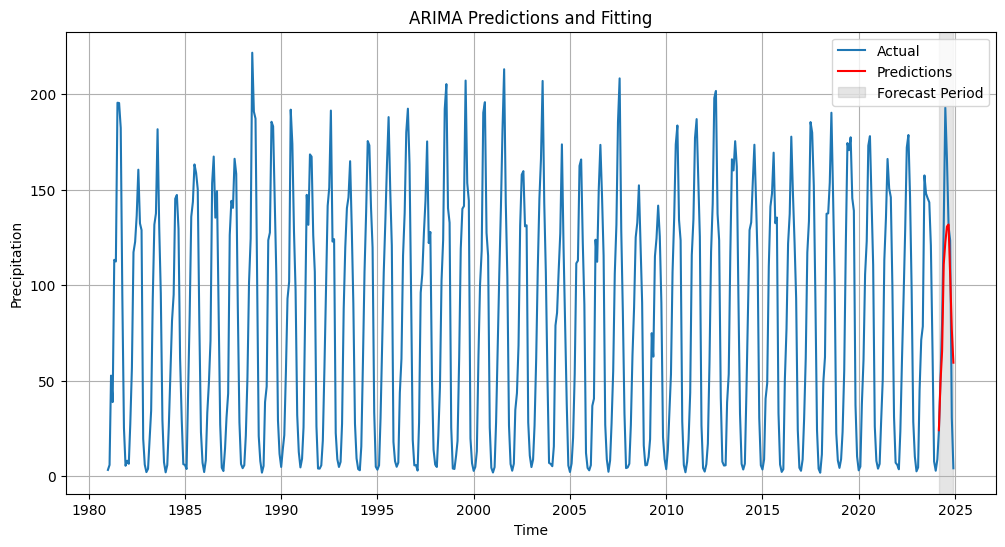

In [ ]:
# Plot results

plt.figure(figsize=(12, 6))

# Plot the original time series
plt.plot(south_sudan_time_series.index, south_sudan_time_series.values, label='Actual')

# Plot the ARIMA predictions
plt.plot(predictions.index, predictions.values, label='Predictions', color='red')

# Highlight the forecast period
plt.axvspan(predictions.index[0], predictions.index[-1], alpha=0.2, color='gray', label='Forecast Period')

plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.title('ARIMA Predictions and Fitting')
plt.legend()
plt.grid(True)
plt.show()
# It seems that the ARIMA is decent in predicting the next 2 percent based on the historic 98 percent

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA forecasting using all available historic data to predict trend
# Here, we train the model on all available data, and try to predict the trend for the next 24 months

forecast_horizon = 24 # time steps in months (will forecast 24 months)
model = ARIMA(south_sudan_time_series, order=(1, 0, 12))  # Replace (p, d, q) with appropriate values
model_fit = model.fit()
predictions = model_fit.predict(start=len(south_sudan_time_series), end=len(south_sudan_time_series) + forecast_horizon)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


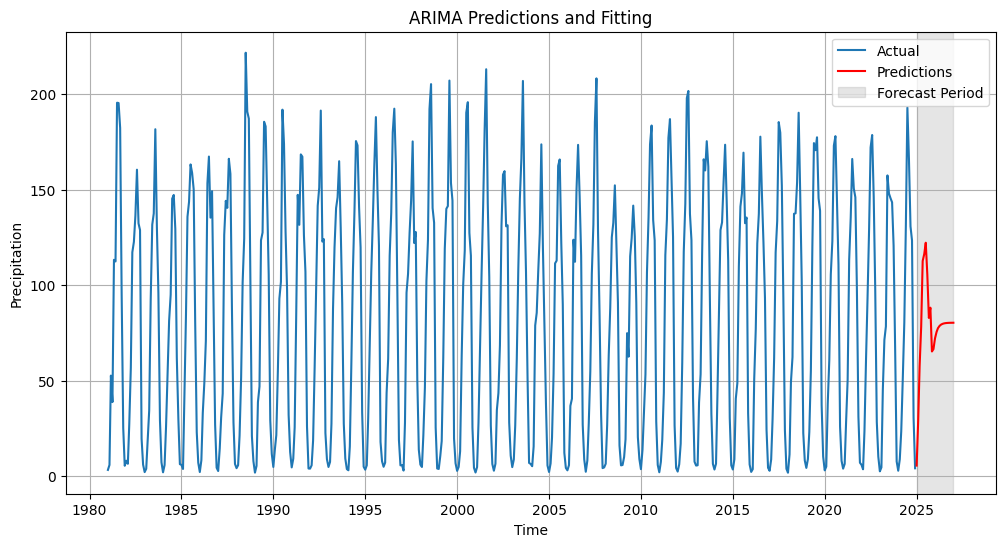

In [ ]:
# Plot results

plt.figure(figsize=(12, 6))

# Plot the original time series
plt.plot(south_sudan_time_series.index, south_sudan_time_series.values, label='Actual')

# Plot the ARIMA predictions
plt.plot(predictions.index, predictions.values, label='Predictions', color='red')

# Highlight the forecast period
plt.axvspan(predictions.index[0], predictions.index[-1], alpha=0.2, color='gray', label='Forecast Period')

plt.xlabel('Time')
plt.ylabel('Precipitation')
plt.title('ARIMA Predictions and Fitting')
plt.legend()
plt.grid(True)
plt.show()
# We see that prediction falls off after 18 months or so